In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss
from pandas.plotting import scatter_matrix
import sklearn.preprocessing as sp

###  データの読み込み Loading data

In [25]:
data = pd.read_csv("data/sales.csv", delimiter=",")
print(data.head())
data.dropna(inplace=True) #欠損値NaNを除外  Remove missing values
print(data.head())
data["weather"].unique()

   humidity  price  sales  temperature weather
0      29.5    290  229.7         17.8   rainy
1      38.1    290  206.1         26.1   rainy
2      31.5    290  202.5         22.0   rainy
3      39.7    290  195.5         23.0   rainy
4      24.7    290  214.4         14.5   rainy
   humidity  price  sales  temperature weather
0      29.5    290  229.7         17.8   rainy
1      38.1    290  206.1         26.1   rainy
2      31.5    290  202.5         22.0   rainy
3      39.7    290  195.5         23.0   rainy
4      24.7    290  214.4         14.5   rainy


array(['rainy', 'sunny'], dtype=object)

In [26]:
data = pd.get_dummies(data, drop_first=True)
print(data.head())

   humidity  price  sales  temperature  weather_sunny
0      29.5    290  229.7         17.8              0
1      38.1    290  206.1         26.1              0
2      31.5    290  202.5         22.0              0
3      39.7    290  195.5         23.0              0
4      24.7    290  214.4         14.5              0


### 散布図の図示 Scatter matrix

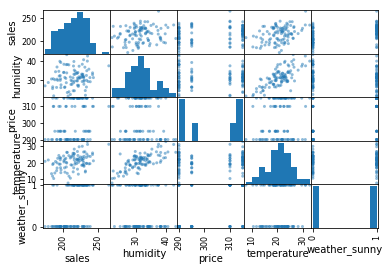

In [28]:
X = data[["humidity","price","temperature","weather_sunny"]] # 独立（説明）変数 independent variable
y = data[['sales']] # 従属（目的）変数 dependent  variable
scatter_matrix(data[['sales',"humidity","price","temperature","weather_sunny"]]) # 対散布図をプロット Scatter matrix
plt.show()

### 回帰分析の実行

In [29]:
# ラベル名を用いるときのモデルの設定 Construct a linear regression model
model = smf.ols(formula = "sales ~  price + temperature + weather_sunny", data = data)

# 回帰分析の実行 Execute linear  regression 
results = model.fit()
# 結果を表示　Print results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     21.59
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           9.08e-11
Time:                        17:14:59   Log-Likelihood:                -399.56
No. Observations:                 100   AIC:                             807.1
Df Residuals:                      96   BIC:                             817.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       273.3018     45.177      6.050

1. sales  = 19.9891weather + -0.2541humidity +  -0.3292price + 1.6031temperature + 278.6277  
2. sales = 20.3939weateher + -0.3260price + 1.4179temperature + 273.3018  
当てはまりがいいのはhumidityがないモデル

### マハラノビスの距離の二乗を求める関数を定義 Define a function to find the square of Mahalanobis distance

In [18]:
def Mahala2(vec_x, vec_mean, mat):
    length = mat.shape[0]
    vec_x = np.array(vec_x, dtype='float64')
    vec = np.asmatrix((vec_x - vec_mean).values.reshape(length, 1))
    inv = np.linalg.inv(mat) # 逆行列を求める　Compute the inverse of a matrix.
    mahala2 = vec.T.dot(inv.dot(vec)) 
    return mahala2[0, 0]

### 理論値・予測値の区間推定　Interval estimation of the theoretical value and the predicted value

In [34]:
Sigma = np.asmatrix(data[["price","temperature", "weather_sunny"]].cov()) # 独立変数の分散共分散行列を求める． Variance-covariance matrix of IVs.
n = len(data) # 標本数. Sample size.
dfm = results.df_model # 独立変数の数（モデルの自由度）．　Number of IVs (Model degrees of freedom). 
t_0025 = ss.t.isf(q=0.05/2, df=n-dfm-1) # 自由度 n-dfm-1のt分布の上側2.5パーセント点(= ss.t.ppf(q=0.975, df=n-dfm-1))
vec_mean = data[["price","temperature", "weather_sunny"]].mean() # 独立変数の平均を求める　Find average of independent variables
print(vec_mean)

#観測値に対応する従属変数の信頼区間を求める Find CI of Y on observed values
X = np.array([1, 290, 17.8, 0]) #観測値の設定
hat_y=X.dot(results.params) # Xとresults.paramsの内積を求め従属変数の推定値を求める　Obtain estimated value of dependent variable

D2_0 = Mahala2([290, 17.8, 0], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance

Ve = results.scale #  残差変動の不偏分散． A scale factor for the covariance matrix.
Se_o = np.sqrt((1/n + D2_0 / (n-1)) * Ve) #観測値の場合　In case of observed value

ci_low = hat_y - t_0025 * Se_o# 下側信頼
ci_up = hat_y + t_0025 * Se_o # 上側信頼

print("理論値（theoretical value）:", hat_y)
print("理論値の信頼区間（CI of theoretical value）：({0},{1})".format(ci_low,ci_up))

#予測値（未観測値に対応する従属変数）の信頼区間を求める Find prediction interval of Y on unobserved values
X = np.array([1, 300, 29, 1]) #未観測値の設定
hat_y=X.dot(results.params) # Xとresults.paramsの内積を求め従属変数の推定値を求める　Obtain estimated value of dependent variable

D2_0 = Mahala2([300, 29, 1], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance

Se_p = np.sqrt((1 + 1/n + D2_0 / (n-1)) * Ve) #未観測値の場合　In case of unobserved value

pi_low = hat_y - t_0025 * Se_p# 下側信頼
pi_up = hat_y + t_0025 * Se_p # 上側信頼

print("予測値（Predicted value）:", hat_y)
print("予測値の信頼区間（CI of predicted value）：({0},{1})".format(pi_low,pi_up))

price            302.500
temperature       20.762
weather_sunny      0.500
dtype: float64
理論値（theoretical value）: 203.99937814781867
理論値の信頼区間（CI of theoretical value）：(199.6862617898067,208.31249450583064)
予測値（Predicted value）: 237.01326611440717
予測値の信頼区間（CI of predicted value）：(209.49079034618543,264.53574188262894)


In [31]:
print(results.params)

Intercept        273.301800
price             -0.326001
temperature        1.417860
weather_sunny     20.393871
dtype: float64


### 理論値・予測値の信頼区間の可視化 Visualization of confidence intervals of theoretical and predicted values

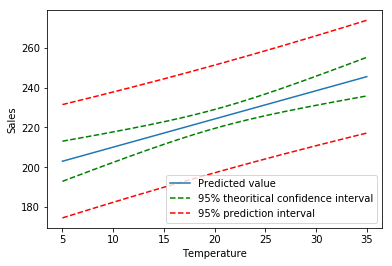

In [37]:
temperature = np.linspace(5, 35, 200) # 100から300までの等差数列を生成

hat_y = []
(price, weather) = (300, 1) # Wind, Tempの値を(10, 78)に固定.　Wind, Temp values are fixed to (10, 78).

for s in temperature:
    X = np.array([1, price, s, weather])
    hat_y.append(X.dot(results.params))# Xとresults.paramsの内積を求め従属変数の推定値を求める Obtain estimated value of dependent variable
plt.plot(temperature, hat_y, label="Predicted value") # 予測値をプロット

D2 = []
for s in temperature:
    D2_0 = Mahala2([price, s, weather], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance
    D2.append(D2_0)
D2 = np.array(D2)

Se_o = np.sqrt((1/n + D2 / (n-1)) * Ve) #観測値の場合　In case of observation value
Se_p = np.sqrt((1 + 1/n + D2 / (n-1)) * Ve) #未観測値の場合　In case of unobserved value

# 観測値に対応する従属変数の信頼区間をプロット
plt.plot(temperature, hat_y - t_0025 * Se_o, "--g", label="95% theoritical confidence interval")
plt.plot(temperature, hat_y + t_0025 * Se_o, "--g")

# 予測値の信頼区間をプロット
plt.plot(temperature, hat_y - t_0025 * Se_p, "--r", label="95% prediction interval")
plt.plot(temperature, hat_y + t_0025 * Se_p, "--r")

plt.xlabel("Temperature")
plt.ylabel("Sales")
plt.legend()
plt.show()